In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

In [2]:
import numpy as np
from itertools import *

In [3]:
real_dtype = tf.float64
cmplx_dtype = tf.complex128

In [77]:
"""
Decomposition of A tensors
A(n, r, l1, l2, ...) = U_1(n, r, l1) * U_2(n, r, l2) * ...

The full tensor can be constructed as follows:
   U_1(n, r, l1)                    -> tildeA(n, r, l1)
   tildeA(n, r, l1) * U_2(n, r, l2) -> tildeA(n, r, l1, l2)
"""

def full_A_tensor(tensors_A):
    Nw = tensors_A[0].shape[0]
    Nr = tensors_A[0].shape[1]
    dim = len(tensors_A)
    
    tildeA = tensors_A[0]
    for i in range(1, dim):
        tildeA_reshaped = tf.reshape(tildeA, (Nw, Nr, -1))
        tildeA = tf.einsum('nrl,nrm->nrlm', tildeA_reshaped, tensors_A[i])
    
    full_tensor_dims = tuple([Nw, Nr] + [t.shape[-1] for t in tensors_A])
    return tf.reshape(tildeA, full_tensor_dims)


In [78]:
N = 4
Nr = 3
Nl = 2

def create_tensor_3(N, M, L):
    rand = np.random.rand(N, M, L) + 1J * np.random.rand(N, M, L)
    return tf.Variable(rand, dtype=cmplx_dtype)

tensors_A = [create_tensor_3(N, Nr, Nl) for i in range(3)]
A = full_A_tensor(tensors_A)

In [170]:
def squared_L2_norm(x):
    """
    Squared L2 norm
    """
    if x.dtype in [tf.float64, tf.float32, tf.float16]:
        return tf.reduce_sum(tf.multiply(x, x))
    elif x.dtype in [tf.complex128, tf.complex64]:
        return tf.reduce_sum(tf.real(tf.multiply(tf.conj(x), x)))
    else:
        raise RuntimeError("Unknown type: " + x.dtype)

def cp_to_full_tensor(x_tensors):
    """
    Construct a full tensor representation
    
    sum_d X_0(d,l0) * X_1(d,l1) * X_2(d,l2) * ...
    
    We contract the tensors from left to right as follows:
        X_0(d, l0) -> tildeT(d, l0)
        tildeT(d,l0) * X_1(d,l1) -> tildeT(d, l0, l1)
    """
    dim = len(x_tensors)
    dims = [x.shape[1] for x in x_tensors]
    D = x_tensors[0].shape[0]
    
    tildeT = x_tensors[0]
    for i in range(1, dim):
        tildeT_reshaped = tf.reshape(tildeT, (D,-1))
        tildeT = tf.einsum('dI,di->dIi', tildeT_reshaped, x_tensors[i])
    full_tensor = tf.reduce_sum(tf.reshape(tildeT, (D,) + tuple(dims)), axis=0)
    assert full_tensor.shape == tf.TensorShape(dims)
    return full_tensor

class OvercompleteGFModel(object):
    """
    minimize |y - A * x|_2^2 + alpha * |x|_2^2
  
    A(n, r, l1, l2, ...) = U_1(n, r, l1) * U_2(n, r, l2) * ...
  
    A_dim: (Nw, Nr, l1, l2, ...)
    freq_dim is the number of l1, l2, ....
    
    x(d, r, l1, l2, ...) = \sum_d X_0(d,r) * X_1(d,l1) * X_2(d,l2) * ...
    """
    def __init__(self, Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):
        self.right_dims = (Nr,) + (linear_dim,) * freq_dim
        self.right_dim = freq_dim + 1
    
        # Check shapes
        assert y.shape == tf.TensorShape([Nw])
        assert len(tensors_A) == freq_dim
        for t in tensors_A:
            assert t.shape == tf.TensorShape([Nw, Nr, linear_dim])
    
        self.y = y
        self.tensors_A = tensors_A
        self.alpha = alpha
        self.Nw = Nw
        self.Nr = Nr
        self.freq_dim = freq_dim
        self.D = D
    
        def create_tensor(N, M):
            rand = np.random.rand(N, M) + 1J * np.random.rand(N, M)
            return tf.Variable(rand, dtype=cmplx_dtype)
    
        self.x_tensors = [create_tensor(D, self.right_dims[i]) for i in range(self.right_dim)]

    def var_list(self):
        """
        Return a list of model parameters
        """
        return self.x_tensors

    def full_tensor_x(self, x_tensors=None):
        if x_tensors == None:
            x_tensors = self.x_tensors
        return cp_to_full_tensor(x_tensors)

    def predict_y(self, x_tensors=None):
        """
        Predict y from self.x_tensors
    
        sum_d sum_{r,l1,l2,...} A(n, r, l1, l2, ...) * X_0(d,r) * X_1(d,l1) * X_2(d,l2) * ...
    
        We used A(n, r, l1, l2, ...) = U_1(n, r, l1) * U_2(n, r, l2) * ...
    
        We contract the tensors as follows:
            U_1(n, r, l1) * X_1(d, l1) -> UX_1(n, r, d)
            U_2(n, r, l2) * X_2(d, l2) -> UX_2(n, r, d)
        """
        if x_tensors == None:
            x_tensors = self.x_tensors
            
        ones = tf.constant(np.full((Nw,),1), dtype=cmplx_dtype)
        result = tf.einsum('dr,n->nrd', x_tensors[0], ones)
        for i in range(1, self.right_dim):
            UX = tf.einsum('nrl,dl->nrd', self.tensors_A[i-1], x_tensors[i])
            result = tf.multiply(result, UX)
        # At this point, "result" is shape of (Nw, Nr, D).
        return tf.reduce_sum(result, axis = [1, 2])

    def loss(self, x_tensors=None):
        """
        Compute mean squared error + L2 regularization term
        """
        if x_tensors == None:
            x_tensors = self.x_tensors
        y_pre = self.predict_y(x_tensors)
        assert self.y.shape == y_pre.shape
        return (squared_L2_norm(self.y - y_pre) + alpha * squared_L2_norm(self.full_tensor_x(x_tensors)))/self.Nw

In [184]:
np.random.seed(100)

Nw = 100
Nr = 1
linear_dim = 2
freq_dim = 2
right_dims = (Nr, Nl, Nl)

def create_tensor_3(N, M, L):
    rand = np.random.rand(N, M, L) + 1J * np.random.rand(N, M, L)
    return tf.Variable(rand, dtype=cmplx_dtype)

tensors_A = [create_tensor_3(Nw, Nr, linear_dim) for i in range(freq_dim)]
y = tf.constant(np.random.randn(Nw) + 1J * np.random.randn(Nw), dtype=cmplx_dtype)

In [185]:
alpha = 0.1
D = 20
model = OvercompleteGFModel(Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D)
%time print("current loss: ", model.loss())

current loss:  tf.Tensor(302.449797090207, shape=(), dtype=float64)
CPU times: user 3.28 ms, sys: 640 µs, total: 3.92 ms
Wall time: 3.28 ms


In [189]:
learning_rate = 0.001

def loss_f():
    loss = model.loss()
    losss.append(loss)
    return loss

def evaluate_loss(model, grads, stepsize):
    #print(model.var_list()[0])
    var_list = [tf.Variable(v) for v in model.var_list()]
    for i in range(len(var_list)):
        var_list[i].assign_sub(stepsize * grads[i])
    return model.loss(var_list)
    
losss = []
diff_losss = []
epochs = range(1000)
tol_rmse = 1e-12
for epoch in epochs:
    # Compute gradients
    with tf.GradientTape() as tape:
        loss = loss_f()
    grads = tape.gradient(loss, model.var_list())
    #print("")
    #print(epoch, loss)

    # Simple line search algorithm
    stepsizes = [0.01*learning_rate, 0.1*learning_rate, learning_rate, 10*learning_rate, 100*learning_rate]
    losss_ls = {}
    for s in stepsizes:
        if not s in losss_ls:
            losss_ls[s] = evaluate_loss(model, grads, s)
    opt_stepsize = min(losss_ls, key = lambda x: losss_ls.get(x))
    #print(losss_ls)
    #print(losss_ls[opt_stepsize])
    
    # Update x
    var_list = model.var_list()
    for i in range(len(var_list)):
        var_list[i].assign_sub(opt_stepsize * grads[i])
    
    if len(losss) > 2:
        diff_losss.append(np.abs(losss[-2] - losss[-1]))
        if losss[-1] < tol_rmse**2 or np.abs(losss[-2] - losss[-1]) < tol_rmse**2:
            break
    

tf.Tensor(1.9304014984011997, shape=(), dtype=float64)


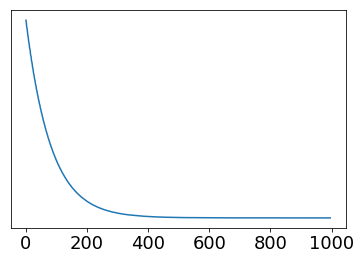

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs[:len(losss)], losss)
plt.yscale("log")
print(losss[-1])

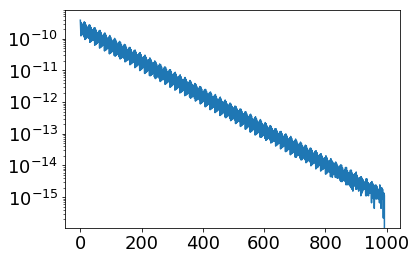

In [192]:
plt.semilogy(diff_losss)

In [193]:
from irbasis_util.regression import ridge_complex

A = full_A_tensor(tensors_A)

Amat = A.numpy().reshape((Nw, -1))
x_corr = ridge_complex(Amat, y.numpy(), alpha)
x_corr

array([-0.24319066+0.18813558j,  0.24302745-0.08420115j,
        0.10191672-0.14802613j, -0.24934885+0.12445611j])

In [194]:
(np.linalg.norm(y - Amat@x_corr)**2)/Nw

1.9301308466032625

In [178]:
#Amat@x_corr

In [195]:
model.full_tensor_x().numpy().reshape((-1))

array([-0.2431903 +0.18813472j,  0.24302704-0.08420036j,
        0.10191644-0.14802528j, -0.24934852+0.12445538j])